In [60]:
import argparse
import os
import glob
import sys
import lxml.etree
from tqdm import tqdm
import spacy
import pandas as pd
import numpy as np
from depid.utils import safe_division
import matplotlib.pyplot as plt
from depid.pid import Depid
os.environ['KMP_DUPLICATE_LIB_OK']='True'
plt.style.use('ggplot')

# I. Test

In [61]:
# Gettysburg Address
p = 'Fourscore and seven years ago our fathers brought forth, on this continent, a new nation, conceived in liberty, and dedicated to the proposition that all men are created equal. Now we are engaged in a great civil war, testing whether that nation, or any nation so conceived, and so dedicated, can long endure. We are met on a great battle-field of that war. We have come to dedicate a portion of that field, as a final resting-place for those who here gave their lives, that that nation might live. It is altogether fitting and proper that we should do this. But, in a larger sense, we cannot dedicate, we cannot consecrate—we cannot hallow—this ground. The brave men, living and dead, who struggled here, have consecrated it far above our poor power to add or detract. The world will little note, nor long remember what we say here, but it can never forget what they did here. It is for us the living, rather, to be dedicated here to the unfinished work which they who fought here have thus far so nobly advanced. It is rather for us to be here dedicated to the great task remaining before us—that from these honored dead we take increased devotion to that cause for which they here gave the last full measure of devotion—that we here highly resolve that these dead shall not have died in vain—that this nation, under God, shall have a new birth of freedom, and that government of the people, by the people, for the people, shall not perish from the earth.'
p

'Fourscore and seven years ago our fathers brought forth, on this continent, a new nation, conceived in liberty, and dedicated to the proposition that all men are created equal. Now we are engaged in a great civil war, testing whether that nation, or any nation so conceived, and so dedicated, can long endure. We are met on a great battle-field of that war. We have come to dedicate a portion of that field, as a final resting-place for those who here gave their lives, that that nation might live. It is altogether fitting and proper that we should do this. But, in a larger sense, we cannot dedicate, we cannot consecrate—we cannot hallow—this ground. The brave men, living and dead, who struggled here, have consecrated it far above our poor power to add or detract. The world will little note, nor long remember what we say here, but it can never forget what they did here. It is for us the living, rather, to be dedicated here to the unfinished work which they who fought here have thus far so 

In [62]:
description = """
Compute PID score by counting dependency types.
"""
parser = argparse.ArgumentParser(description=description)
parser.add_argument('-F', '--folder', help='Input folder containing text files')
parser.add_argument('-f', '--file', help='Single input file')
parser.add_argument('-O', '--output', help="""Write propositions report files into this folder. 
                        If not given then creates a new 'output' folder in the current working directory""")
parser.add_argument('-C', '--conj', action='store_true',
                        help="""
                        Count also conjunctions as propositions. This has the side effect of counting 
                        as propositions the sentence-initial conjunction words that serve as lexical fillers. 
                        """)
args = parser.parse_args()

In [63]:
nlp = spacy.load('en_core_web_sm', disable=["ner"])

prop_counter = Depid(count_conjunctions=args.conj)
txt = nlp(p.strip())
for sent in txt.sents:
    tokens_out = prop_counter.count_propositions(sent)
    for i, (word, lemma, pos, head, dep, tok, prop, rep) in enumerate(tokens_out):
        print(f'{i+1}\t{word}\t{lemma}\t{pos}\t{head}\t{dep}\t{tok}\t{prop}\t{rep}')
num_props = prop_counter.num_propositions()
num_props_rep = prop_counter.num_propositions(rep=True)
num_tokens = prop_counter.num_tokens
prop_id = safe_division(num_props, num_tokens)
prop_rep_id = safe_division(num_props_rep, num_tokens)

print(f'{num_props}\t{num_props_rep}\t{num_tokens}\t{prop_id:.3f}\t{prop_rep_id:.3f}')  
print("-----------------------------------------------------------------------------")

1	Fourscore	fourscore	NOUN	1	ROOT	T		
2	and	and	CCONJ	1	cc	T		
3	seven	seven	NUM	4	nummod	T	nummod: seven year	R
4	years	year	NOUN	5	npadvmod	T	npadvmod: year ago	R
5	ago	ago	ADV	8	advmod	T	advmod: ago bring	R
6	our	our	PRON	7	poss	T	poss: our father	R
7	fathers	father	NOUN	8	nsubj	T	nsubj: father bring	R
8	brought	bring	VERB	1	conj	T		
9	forth	forth	ADV	8	advmod	T	advmod: forth bring	R
10	,	,	PUNCT	8	punct			
11	on	on	ADP	8	prep	T	prep: on bring	R
12	this	this	DET	13	det	T	det: this continent	R
13	continent	continent	NOUN	11	pobj	T	pobj: continent on	R
14	,	,	PUNCT	11	punct			
15	a	a	DET	17	det	T		
16	new	new	ADJ	17	amod	T	amod: new nation	R
17	nation	nation	NOUN	11	pobj	T	pobj: nation on	R
18	,	,	PUNCT	17	punct			
19	conceived	conceive	VERB	17	acl	T		
20	in	in	ADP	19	prep	T	prep: in conceive	R
21	liberty	liberty	NOUN	20	pobj	T	pobj: liberty in	R
22	,	,	PUNCT	19	punct			
23	and	and	CCONJ	19	cc	T		
24	dedicated	dedicate	VERB	19	conj	T		
25	to	to	ADP	24	prep	T	prep: to dedicate	R
26	the

# II. Prepare Pratchett Corpus

In [65]:
NSMAP = {'tei': 'http://www.tei-c.org/ns/1.0'}

def get_alltext_from_plist(plist) -> str:
    textlist = []
    for item in plist:
        if isinstance(item.text, str):
            textlist.append(item.text)
    alltext = "\n".join(textlist)
    return alltext

os.chdir('C:/Users/Dora Sperling/Desktop/Thesis/xml_files')
directory = 'C:/Users/Dora Sperling/Desktop/Thesis/xml_files'

In [66]:
def get_metadata_df(directory):
    '''
    Takes the directory containing the Pratchett full text files.
    Returns them as a dataframe with basic metadata and the full tokenized text. 
    '''
    ya_novels = ["Johnny and the Bomb", 'Only You Can Save Mankind', 'Johnny and the Dead',
                 'The Wee Free Men', 'A Hat Full of Sky', "Wintersmith", 'Nation', 'I Shall Wear Midnight',
                "The Shepherd's Crown", 'The Amazing Maurice and His Educated Rodents']
    titles = []
    ages = []
    years = []
    young_adult = []
    texts = []
    for file in tqdm(os.scandir(directory)):
        if file.name.endswith(".xml"):
            tree = lxml.etree.parse(file.name)
            root = tree.getroot()
            # Get the book's title
            title = root.find("./tei:teiHeader/tei:fileDesc/tei:sourceDesc//tei:title", 
                              namespaces=NSMAP).text
            
            # Get the year the book was published
            year_of_publication = root.find("./tei:teiHeader/tei:profileDesc/tei:particDesc//tei:age", 
                                            namespaces=NSMAP).attrib['when']
            
            # Get the age that Terry Pratchett was when the book was published 
            age_at_publication = root.find("./tei:teiHeader/tei:profileDesc/tei:particDesc//tei:age", 
                                           namespaces=NSMAP).attrib['value']
            
            # Get a list of all the paragraph elements
            plist = root.findall("./tei:text//tei:p", namespaces=NSMAP)
            text = get_alltext_from_plist(plist)
            
            # Determine whether the book is in the list of books for younger readers 
            if title in ya_novels:
                 ya=True
            else:
                 ya=False
            
            # Add all above information to lists to be made into a dataframe
            titles.append(title)
            ages.append(age_at_publication)
            years.append(year_of_publication)
            young_adult.append(ya)
            texts.append(text)
    
    # Paste finished lists together into dataframe
    
    df = pd.DataFrame({'title': titles, 
                   'year_of_publication':years, 
                   'age_at_publication':ages,
                    'YA':young_adult,
                   'text':texts})  
    
    # Do not include a default index column, sort by Terry Pratchett's age in ascending order
    df = df.sort_values(by='age_at_publication').reset_index(drop=True)
    return df

In [67]:
metadata_df = get_metadata_df('C:/Users/Dora Sperling/Desktop/Thesis/xml_files')

47it [00:01, 44.50it/s]


In [68]:
metadata_df = metadata_df[metadata_df.YA == False].reset_index(drop=True)
metadata_df

,title,year_of_publication,age_at_publication,YA,text
0,The Color Of Magic,1983,35.58,False,"In A distant and secondhand set of dimensions,..."
1,The Light Fantastic,1986,38.10,False,"The sun rose slowly, as if it wasn’t sure it w..."
2,Equal Rites,1987,38.72,False,This is a story about magic and where it goes ...
3,Mort,1987,39.51,False,This is the bright candlelit room where the li...
4,Sourcery,1988,40.08,False,There was a man and he had eight sons. Apart f...
5,Wyrd Sisters,1988,40.54,False,The wind howled. Lightning stabbed at the eart...
6,Pyramids,1989,41.13,False,"Nothing but stars, scattered across the blackn..."
7,Guards! Guards!,1989,41.53,False,This is where the dragons went.\nThey lie...\n...
8,Eric,1990,42.30,False,"The bees of Death are big and black, they buzz..."
9,Moving Pictures,1990,42.51,False,Watch...\nThis is space. It’s sometimes called...


# III. DEPID - Full Text

In [70]:
prop_idea_density = []


for book in metadata_df.text:
    prop_counter = Depid(count_conjunctions=args.conj)
    ps = book.split('\n')    
    for p in ps:
        txt = nlp(p.strip())
        for sent in txt.sents:
            tokens_out = prop_counter.count_propositions(sent)
#             for i, (word, lemma, pos, head, dep, tok, prop, rep) in enumerate(tokens_out):
#                 #print(f'{i+1}\t{word}\t{lemma}\t{pos}\t{head}\t{dep}\t{tok}\t{prop}\t{rep}')
    num_props = prop_counter.num_propositions()

    num_tokens = prop_counter.num_tokens
    prop_id = safe_division(num_props, num_tokens)
    prop_idea_density.append(prop_id)
    
    print(f'{num_props}\t{num_tokens}\t{prop_id:.3f}')  
    print("-----------------------------------------------------------------------------")



33989	66490	0.511
-----------------------------------------------------------------------------
22784	45986	0.495
-----------------------------------------------------------------------------
33279	67367	0.494
-----------------------------------------------------------------------------
36860	73918	0.499
-----------------------------------------------------------------------------
39878	79476	0.502
-----------------------------------------------------------------------------
42471	86244	0.492
-----------------------------------------------------------------------------
43820	88215	0.497
-----------------------------------------------------------------------------
48573	99774	0.487
-----------------------------------------------------------------------------
16962	34862	0.487
-----------------------------------------------------------------------------
47292	98642	0.479
-----------------------------------------------------------------------------
37885	79350	0.477
----------------------

In [71]:
metadata_df.age_at_publication = pd.to_numeric(metadata_df.age_at_publication, downcast="float")

Text(0.5, 0, 'Age at publication (years)')

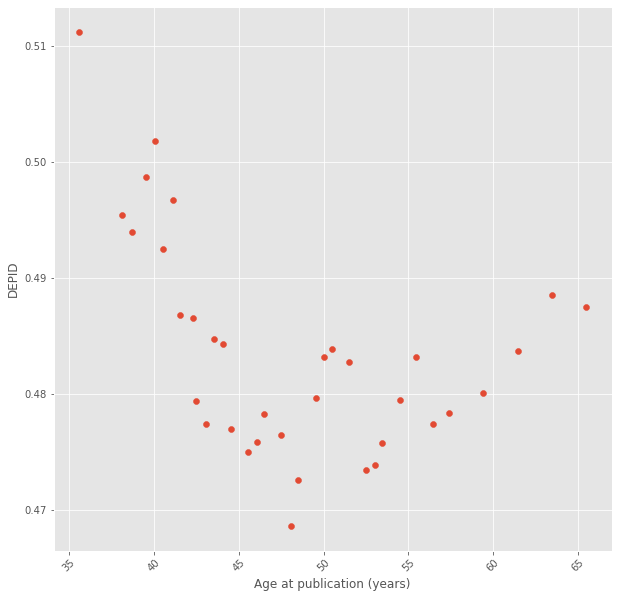

In [72]:
f, ax = plt.subplots(figsize=(10,10))

ax.scatter(metadata_df.age_at_publication, prop_idea_density)
#ax.errorbar(metadata_df.age_at_publication, mean_ttr_2000tok, yerr=std_ttr_2000tok, fmt="o")

plt.xticks(rotation=45);
ax.set_ylabel('DEPID')
ax.set_xlabel('Age at publication (years)')

# IV. DEPID-R - 100-paragraph segments

In [73]:
def get_chunks(text, windowsize):
    '''
    Takes a text, and divides it into non-overlapping segments.
    Returns the segments as a list. 
    '''
    tokenlist = text.split()
    chunks = []
    for i in range(0, len(tokenlist), windowsize):
        if len(tokenlist[i:i + windowsize]) == windowsize: # do not include trailing words after the the last whole segment
            chunks.append(" ".join(tokenlist[i:i + windowsize]))
    return chunks

In [74]:
for ii, book in enumerate(metadata_df.text):
    ps = book.split('\n')
    chunks = []
    for i in range(0, len(ps), 100):
        if len(ps[i:i + 100]) == 100: # do not include trailing words after the the last whole segment
            chunks.append(ps[i:i + 100])
    print(ii, len(chunks))

0 24
1 21
2 28
3 34
4 38
5 41
6 39
7 45
8 16
9 52
10 48
11 44
12 52
13 51
14 56
15 57
16 51
17 48
18 48
19 52
20 57
21 46
22 50
23 56
24 52
25 50
26 20
27 49
28 50
29 44
30 43
31 45
32 48
33 24
34 24


In [77]:
mean_prop_rep_idea_density = []

for book in metadata_df.text:
    ps = book.split('\n')
    chunks = []
    
    # Get a list of chunks containing 100 paragraph elements each
    for i in range(0, len(ps), 100):
        if len(ps[i:i + 100]) == 100: # do not include trailing words after the the last whole segment
            chunks.append(ps[i:i + 100])
    
    # Initialize lists to store DEPID-R measurements in 
    book_rep_idea_densities_per100_paragraphs = []
    
    for chunk in tqdm(chunks):
        # reset proposition counter
        prop_counter = Depid(count_conjunctions=args.conj)
        
        # Count propositions in each of the 100 paragraph elements
        for p in chunk:
            txt = nlp(p.strip())
            for sent in txt.sents:
                tokens_out = prop_counter.count_propositions(sent)
                
        num_props = prop_counter.num_propositions()
        num_props_rep = prop_counter.num_propositions(rep=True)
        num_tokens = prop_counter.num_tokens

        prop_rep_id = safe_division(num_props_rep, num_tokens)
        
        book_rep_idea_densities_per100_paragraphs.append(prop_rep_id)
    
    # Add the mean DEPID-R of the book to the list of mean DEPIDs
    
    mean_prop_rep_idea_density.append(np.mean(book_rep_idea_densities_per100_paragraphs))
    
    print(f'\t{np.mean(book_rep_idea_densities_per100_paragraphs):.3f}') 
    print("-------------")


  0%|                                                                                           | 0/21 [00:00<?, ?it/s]

	0.459
-------------


  0%|                                                                                           | 0/28 [00:00<?, ?it/s]

	0.435
-------------


  0%|                                                                                           | 0/34 [00:00<?, ?it/s]

	0.434
-------------


  0%|                                                                                           | 0/38 [00:00<?, ?it/s]

	0.441
-------------


  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

	0.445
-------------


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

	0.431
-------------


  0%|                                                                                           | 0/45 [00:00<?, ?it/s]

	0.434
-------------


  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

	0.425
-------------


  0%|                                                                                           | 0/52 [00:00<?, ?it/s]

	0.421
-------------


  0%|                                                                                           | 0/48 [00:00<?, ?it/s]

	0.417
-------------


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

	0.423
-------------


  0%|                                                                                           | 0/52 [00:00<?, ?it/s]

	0.418
-------------


  0%|                                                                                           | 0/51 [00:00<?, ?it/s]

	0.421
-------------


  0%|                                                                                           | 0/56 [00:00<?, ?it/s]

	0.419
-------------


  0%|                                                                                           | 0/57 [00:00<?, ?it/s]

	0.415
-------------


  0%|                                                                                           | 0/51 [00:00<?, ?it/s]

	0.416
-------------


  0%|                                                                                           | 0/48 [00:00<?, ?it/s]

	0.419
-------------


  0%|                                                                                           | 0/48 [00:00<?, ?it/s]

	0.421
-------------


  0%|                                                                                           | 0/52 [00:00<?, ?it/s]

	0.413
-------------


  0%|                                                                                           | 0/57 [00:00<?, ?it/s]

	0.413
-------------


  0%|                                                                                           | 0/46 [00:00<?, ?it/s]

	0.422
-------------


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

	0.421
-------------


  0%|                                                                                           | 0/56 [00:00<?, ?it/s]

	0.424
-------------


  0%|                                                                                           | 0/52 [00:00<?, ?it/s]

	0.427
-------------


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

	0.410
-------------


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

	0.412
-------------


  0%|                                                                                           | 0/49 [00:00<?, ?it/s]

	0.412
-------------


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

	0.416
-------------


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

	0.420
-------------


  0%|                                                                                           | 0/43 [00:00<?, ?it/s]

	0.411
-------------


  0%|                                                                                           | 0/45 [00:00<?, ?it/s]

	0.414
-------------


  0%|                                                                                           | 0/48 [00:00<?, ?it/s]

	0.417
-------------


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

	0.410
-------------


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

	0.406
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:25<00:00,  1.05s/it]

	0.416
-------------


Text(0.5, 0, 'Age at publication (years)')

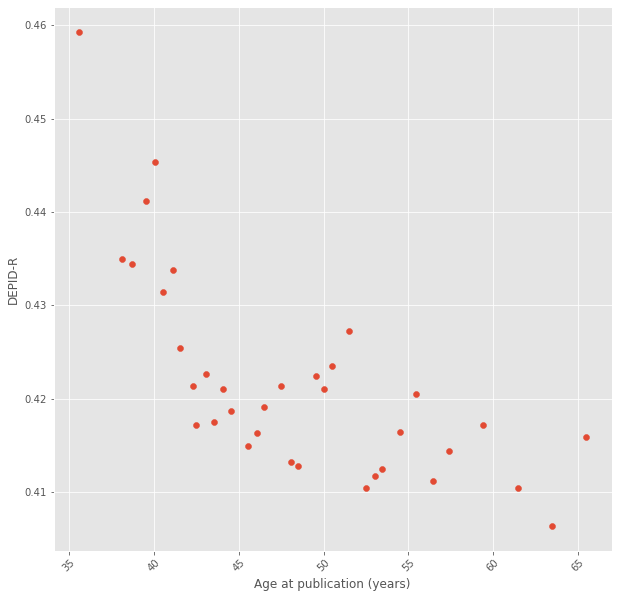

In [78]:
f, ax = plt.subplots(figsize=(10,10))

ax.scatter(metadata_df.age_at_publication, mean_prop_rep_idea_density)


plt.xticks(rotation=45);
ax.set_ylabel('DEPID-R')
ax.set_xlabel('Age at publication (years)')

In [80]:
from scipy.stats import kendalltau

In [85]:
problematic_books = []


for i in range(metadata_df.shape[0]):
    book = metadata_df.loc[i, 'text']
    ps = book.split('\n')
    chunks = []
    
    # Get a list of chunks containing 100 paragraph elements each
    for ii in range(0, len(ps), 100):
        if len(ps[ii:ii + 100]) == 100: # do not include trailing words after the the last whole segment
            chunks.append(ps[ii:ii + 100])
    
    # Initialize lists to store DEPID-R measurements in 
    book_rep_idea_densities_per100_paragraphs = []
    
    for chunk in tqdm(chunks):
        # reset proposition counter
        prop_counter = Depid(count_conjunctions=args.conj)
        
        # Count propositions in each of the 100 paragraph elements
        for p in chunk:
            txt = nlp(p.strip())
            for sent in txt.sents:
                tokens_out = prop_counter.count_propositions(sent)
                
        num_props = prop_counter.num_propositions()
        num_props_rep = prop_counter.num_propositions(rep=True)
        num_tokens = prop_counter.num_tokens

        prop_rep_id = safe_division(num_props_rep, num_tokens)
        
        book_rep_idea_densities_per100_paragraphs.append(prop_rep_id)
     
    num_indices = len(book_rep_idea_densities_per100_paragraphs)
    tau_results = kendalltau(range(num_indices), book_rep_idea_densities_per100_paragraphs)
    print(tau_results)
    if tau_results[1] <= 0.05:
        print("Repetition rates vary significantly with place in text: " + metadata_df.loc[i, 'title'])
        print("\tKendall's tau: " + str(tau_results[0]))
        problematic_books.append(metadata_df.loc[i, 'title'])

  0%|                                                                                           | 0/21 [00:00<?, ?it/s]

KendalltauResult(correlation=0.16666666666666669, pvalue=0.2675071977260416)


  0%|                                                                                           | 0/28 [00:00<?, ?it/s]

KendalltauResult(correlation=-0.29523809523809524, pvalue=0.06493357769830031)


  0%|                                                                                           | 0/34 [00:00<?, ?it/s]

KendalltauResult(correlation=0.07407407407407407, pvalue=0.5969690066080101)


  0%|                                                                                           | 0/38 [00:00<?, ?it/s]

KendalltauResult(correlation=0.08021390374331552, pvalue=0.5047082923756476)


  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

KendalltauResult(correlation=-0.052631578947368425, pvalue=0.6418165399455933)


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

KendalltauResult(correlation=-0.18536585365853658, pvalue=0.08777474156950767)


  0%|                                                                                           | 0/45 [00:00<?, ?it/s]

KendalltauResult(correlation=-0.07692307692307693, pvalue=0.49049500055979334)


  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

KendalltauResult(correlation=0.07676767676767676, pvalue=0.4572054683185859)


  0%|                                                                                           | 0/52 [00:00<?, ?it/s]

KendalltauResult(correlation=-0.19999999999999998, pvalue=0.3057265481534429)


  0%|                                                                                           | 0/48 [00:00<?, ?it/s]

KendalltauResult(correlation=0.15233785822021118, pvalue=0.11093661355967166)


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

KendalltauResult(correlation=-0.009756098520272663, pvalue=0.9221130986855427)


  0%|                                                                                           | 0/52 [00:00<?, ?it/s]

KendalltauResult(correlation=0.02959830866807611, pvalue=0.7770240309114536)


  0%|                                                                                           | 0/51 [00:00<?, ?it/s]

KendalltauResult(correlation=-0.10256410256410256, pvalue=0.28318750066025977)


  0%|                                                                                           | 0/56 [00:00<?, ?it/s]

KendalltauResult(correlation=0.04470588235294118, pvalue=0.6433887141131246)


  0%|                                                                                           | 0/57 [00:00<?, ?it/s]

KendalltauResult(correlation=-0.02727272727272728, pvalue=0.7665913629461374)


  0%|                                                                                           | 0/51 [00:00<?, ?it/s]

KendalltauResult(correlation=0.030075187969924817, pvalue=0.7410790442047155)


  0%|                                                                                           | 0/48 [00:00<?, ?it/s]

KendalltauResult(correlation=-0.18431372549019612, pvalue=0.05629827186566439)


  0%|                                                                                           | 0/48 [00:00<?, ?it/s]

KendalltauResult(correlation=0.010638297872340427, pvalue=0.915061506100966)


  0%|                                                                                           | 0/52 [00:00<?, ?it/s]

KendalltauResult(correlation=-0.05141843971631206, pvalue=0.6061992398238222)


  0%|                                                                                           | 0/57 [00:00<?, ?it/s]

KendalltauResult(correlation=-0.10407239819004525, pvalue=0.2761677627161072)


  0%|                                                                                           | 0/46 [00:00<?, ?it/s]

KendalltauResult(correlation=-0.15664160401002508, pvalue=0.08525767775033599)


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

KendalltauResult(correlation=0.0009661835748792271, pvalue=0.9924456207213618)


  0%|                                                                                           | 0/56 [00:00<?, ?it/s]

KendalltauResult(correlation=-0.044897959183673466, pvalue=0.6454680027221649)


  0%|                                                                                           | 0/52 [00:00<?, ?it/s]

KendalltauResult(correlation=-0.07272727272727274, pvalue=0.4286149963228659)


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

KendalltauResult(correlation=-0.3936651583710407, pvalue=3.8028601951543816e-05)
Repetition rates vary significantly with place in text: The Truth
	Kendall's tau: -0.3936651583710407


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

KendalltauResult(correlation=-0.09551020408163266, pvalue=0.3277339857249213)


  0%|                                                                                           | 0/49 [00:00<?, ?it/s]

KendalltauResult(correlation=-0.3473684210526316, pvalue=0.033643947242160896)
Repetition rates vary significantly with place in text: The Last Hero
	Kendall's tau: -0.3473684210526316


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

KendalltauResult(correlation=0.08163265306122447, pvalue=0.40795133408745543)


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

KendalltauResult(correlation=-0.20816326530612245, pvalue=0.0329215491285852)
Repetition rates vary significantly with place in text: Monstrous Regiment
	Kendall's tau: -0.20816326530612245


  0%|                                                                                           | 0/43 [00:00<?, ?it/s]

KendalltauResult(correlation=-0.25581395348837205, pvalue=0.014379066957998192)
Repetition rates vary significantly with place in text: Going Postal
	Kendall's tau: -0.25581395348837205


  0%|                                                                                           | 0/45 [00:00<?, ?it/s]

KendalltauResult(correlation=-0.034330011074197114, pvalue=0.7456139970722526)


  0%|                                                                                           | 0/48 [00:00<?, ?it/s]

KendalltauResult(correlation=-0.0404040404040404, pvalue=0.6955808273182372)


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

KendalltauResult(correlation=-0.3510638297872341, pvalue=0.0004320938371330456)
Repetition rates vary significantly with place in text: Unseen Academicals
	Kendall's tau: -0.3510638297872341


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

KendalltauResult(correlation=-0.24637681159420288, pvalue=0.09679484130838545)


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:17<00:00,  1.41it/s]

KendalltauResult(correlation=0.057971014492753624, pvalue=0.7128203407600773)


In [86]:
problematic_books

['The Truth',
 'The Last Hero',
 'Monstrous Regiment',
 'Going Postal',
 'Unseen Academicals']

Text(0.5, 0, 'Age at publication (years)')

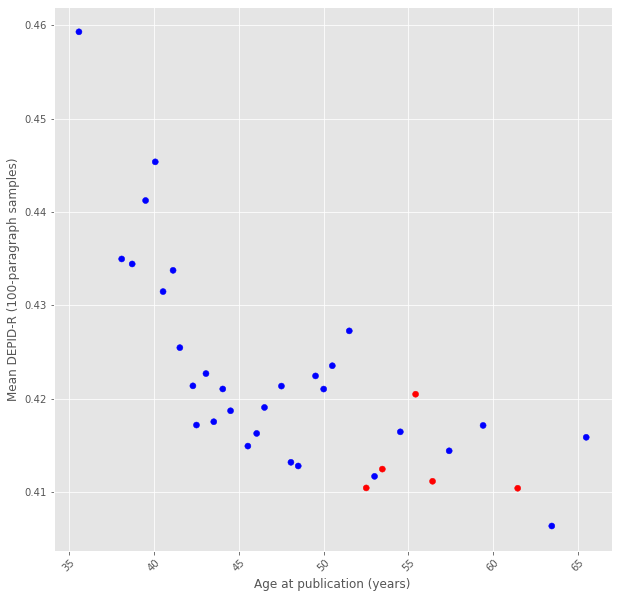

In [87]:
col =[]
  
for title in metadata_df.title:
    if title not in problematic_books:
        col.append('blue')  
    else:
        col.append('red')
        
f, ax = plt.subplots(figsize=(10,10))

ax.scatter(metadata_df.age_at_publication, mean_prop_rep_idea_density, c=col)
#ax.errorbar(metadata_df.age_at_publication, mean_ttr_2000tok, yerr=std_ttr_2000tok, fmt="o")


plt.xticks(rotation=45);
ax.set_ylabel('Mean DEPID-R (100-paragraph samples)')
ax.set_xlabel('Age at publication (years)')

In [88]:
DEPIDR_sig_internal_variation = [True if title in problematic_books else False for title in metadata_df.title]
DEPIDR_sig_internal_variation

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 False]

In [89]:
metadata_df['propositional_idea_density'] = prop_idea_density

metadata_df['mean_propositional_rep_idea_density_100p'] = mean_prop_rep_idea_density
metadata_df['DEPIDR_sig_internalvar'] = DEPIDR_sig_internal_variation


notext = metadata_df.drop(['text'], axis=1)
notext

,title,year_of_publication,age_at_publication,YA,propositional_idea_density,mean_propositional_rep_idea_density_100p,DEPIDR_sig_internalvar
0,The Color Of Magic,1983,35.580002,False,0.511190,0.459283,False
1,The Light Fantastic,1986,38.099998,False,0.495455,0.434966,False
2,Equal Rites,1987,38.720001,False,0.493996,0.434429,False
3,Mort,1987,39.509998,False,0.498661,0.441223,False
4,Sourcery,1988,40.080002,False,0.501762,0.445362,False
5,Wyrd Sisters,1988,40.540001,False,0.492452,0.431473,False
6,Pyramids,1989,41.130001,False,0.496741,0.433746,False
7,Guards! Guards!,1989,41.529999,False,0.486830,0.425471,False
8,Eric,1990,42.299999,False,0.486547,0.421379,False
9,Moving Pictures,1990,42.509998,False,0.479431,0.417183,False


In [90]:
os.chdir('C:/Users/Dora Sperling/Desktop/Thesis')
notext.to_csv("propositional_ID_df.csv", index=False, encoding='utf8')